# Árboles de decisión

In [24]:
import numpy as np
import pandas as pd
import matplotlib 
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, RocCurveDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn import tree

from preprocessing import *

plt.rcParams["figure.dpi"] = 60

# Carga del dataset
Leemos el dataset y lo separamos en datos de training y de evaluación.

In [5]:
df = pd.read_csv("df_train.csv")
X = df.drop(columns=['llovieron_hamburguesas_al_dia_siguiente'])
y = df['llovieron_hamburguesas_al_dia_siguiente']
X_train, X_eval, y_train, y_eval = train_test_split(X, y, random_state=117, test_size=0.1, stratify=y.astype(str))

# Selección de modelos

Para encontrar el mejor modelo, probaremos utilizando 4 preprocesamientos distintos. Por cada uno de ellos, buscaremos la mejor combinación de hiperparámetros mediante Randomized Search, con el objetivo de maximizar la métrica AUC ROC.

Los hiperparámetros que buscaremos son:
- **max_depth:** es la máxima profundidad que puede tener el árbol. Probaremos con valores entre 1 y 15, ya que para valores más grandes es muy probable que ocurra overfitting, al acercarse la cantidad de hojas a la cantidad de instancias.
- **min_samples_leaf:** la mínima cantidad de muestras en cada nodo hoja. En este caso probaremos con un rango amplio de valores, entre 1 y 300.
- **criterion:** es el criterio para determinar qué feature se agrega al arbol en un nodo nuevo en cada iteración. Hay dos criterios: *gini* (busca reducir la impureza de Gini) y *entropy* (busca reducir la entropía). Los dos criterios se suelen utilizar mucho en la práctica, por lo tanto probaremos con ambos.

En primer lugar probamos con el dataset completo, codificando las variables categóricas con One Hot Encoding:

In [6]:
X_train1 = preprocessing_arboles_1(X_train)
params = {
    'max_depth': np.arange(1, 15),
    'min_samples_leaf': np.arange(1, 300),
    "criterion": ["gini", "entropy"],
}

clf1 = tree.DecisionTreeClassifier(random_state=117)

rgscv1 = RandomizedSearchCV(
    clf1, params, n_iter = 180, scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train1, y_train)

print(f"Best score: {rgscv1.best_score_}")
print(f"Best params {rgscv1.best_params_}")

Best score: 0.8567452572514875
Best params {'min_samples_leaf': 122, 'max_depth': 9, 'criterion': 'entropy'}


El segundo preprocesamiento elimina los features categóricos:

In [7]:
X_train2 = preprocessing_arboles_2(X_train)
params = {
    'max_depth': np.arange(1, 15),
    'min_samples_leaf': np.arange(1, 300),
    "criterion": ["gini", "entropy"],
}

clf2 = tree.DecisionTreeClassifier(random_state=117)

rgscv2 = RandomizedSearchCV(
    clf2, params, n_iter = 180, scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train2, y_train)

print(f"Best score: {rgscv2.best_score_}")
print(f"Best params {rgscv2.best_params_}")

Best score: 0.856347769040689
Best params {'min_samples_leaf': 154, 'max_depth': 9, 'criterion': 'entropy'}


El tercer preprocesamiento elimina columnas con alta cantidad de valores faltantes, y aplica One Hot Encoding para las variables categóricas:

In [8]:
X_train3 = preprocessing_arboles_3(X_train)
params = {
    'max_depth': np.arange(1, 15),
    'min_samples_leaf': np.arange(1, 300),
    "criterion": ["gini", "entropy"],
}

clf3 = tree.DecisionTreeClassifier(random_state=117)

rgscv3 = RandomizedSearchCV(
    clf3, params, n_iter = 180, scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train3, y_train)

print(f"Best score: {rgscv3.best_score_}")
print(f"Best params {rgscv3.best_params_}")

Best score: 0.8500166727120112
Best params {'min_samples_leaf': 116, 'max_depth': 10, 'criterion': 'entropy'}


Por último, probamos con un preprocesamiento que elimina todos los features que consideramos irrelevantes de acuerdo a los análisis del TP1:

In [9]:
X_train4 = preprocessing_arboles_4(X_train)
params = {
    'max_depth': np.arange(1, 15),
    'min_samples_leaf': np.arange(1, 300),
    "criterion": ["gini", "entropy"],
}

clf4 = tree.DecisionTreeClassifier(random_state=117)

rgscv4 = RandomizedSearchCV(
    clf4, params, n_iter = 180, scoring='roc_auc', n_jobs=-1, cv=5, return_train_score=True
).fit(X_train4, y_train)

print(f"Best score: {rgscv4.best_score_}")
print(f"Best params {rgscv4.best_params_}")

Best score: 0.8493119094136488
Best params {'min_samples_leaf': 176, 'max_depth': 11, 'criterion': 'gini'}


Comparando los resultados obtenidos, se puede ver que el parámetro min_samples_leaf está entre 100 y 200 en todos los casos. No se obtuvieron valores pequeños (cercanos a 1), los cuales favorecerían el overfitting. De igual modo, max_depth está entre 9 y 11, los cuales no son valores altos que favorecen el overfitting. Por último, vemos que el criterio que prevaleció en 3 de las 4 búsquedas es el de entropy.

En cuanto a las métricas, el dataset que tuvo mejor performance fue el primero, aunque la diferencia no es muy grande respecto de los otros.

# Evaluación del modelo final

El mejor modelo encontrado corresponde al preprocesamiento preprocessing_arboles_1 , con 'min_samples_leaf': 122, 'max_depth': 9, 'criterion': 'entropy'.
Entrenamos el modelo y evaluamos utilizando el set de evaluación.

In [14]:
X_eval = preprocessing_arboles_1(X_eval)

clf = tree.DecisionTreeClassifier(random_state=117, max_depth=9, min_samples_leaf=122, criterion='entropy')
clf.fit(X_train1, y_train)

y_pred = clf.predict(X_eval)
y_pred_proba = clf.predict_proba(X_eval)[:,1]

In [15]:
print(f"Auc Roc: {roc_auc_score(y_eval, y_pred_proba)}")
print(f"Accuracy: {accuracy_score(y_eval, y_pred)}")
print(f"Precision: {precision_score(y_eval, y_pred)}")
print(f"Recall: {recall_score(y_eval, y_pred)}")
print(f"F1 Score: {f1_score(y_eval, y_pred)}")

Auc Roc: 0.8585987020353779
Accuracy: 0.8408114319976017
Precision: 0.7035076108537393
Recall: 0.48143115942028986
F1 Score: 0.5716590481312182


De las métricas podemos destacar que se obtuvo un accuracy de 0.84, ligeramente mayor que el accuracy del baseline obtenido en el TP1 (0.83). Dado que el accuracy no es una buena métrica para evaluar un modelo cuando se usa un dataset desbalanceado como este, la métrica que usamos para comparar los modelos es AUC, la cual tiene un valor de 0.86.

También vemos que el recall obtenido (0.48) es mucho menor que el precision (0.70). Esto significa que, de todas las instancias que son realmente positivas (es decir, llueven hamburguesas al día siguiente), el modelo solo detecta correctamente el 48% de ellas. Por otro lado, de las que el modelo predice como positivas, el 70% eran realmente positivas.

Particularmente el recall no es bueno, ya que el modelo detecta correctamente menos de la mitad de las instancias positivas.
Sin embargo, dado que el árbol de decisión es uno de los modelos más simples, y se suele utilizar como baseline, no se espera que tenga una performance muy alta.

Por último, el F1 Score permite tener una única métrica para evaluar el modelo, teniendo en cuenta el recall y el precision:

    F1 = 2 x (precision x recall) / (precision + recall) = 0.57

Para analizar con más detalle estas métricas, graficaremos la matriz de confusión y la curva ROC.

## Matriz de confusión

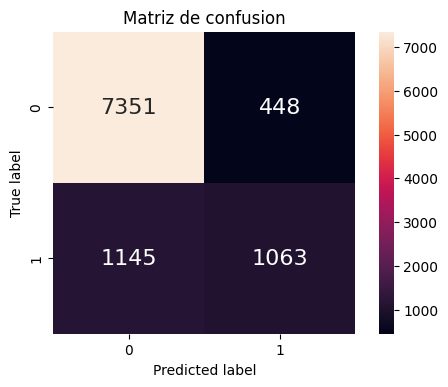

In [25]:
names = sorted(set(y_eval))
cm = confusion_matrix(y_eval, y_pred)
df_cm = pd.DataFrame(cm, names, names)

plt.figure(dpi=100)
plt.title("Matriz de confusion")
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', square=True)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

En la matriz de confusión podemos observar exactamente cuántas instancias fueron predichas como True Positive, True Negative, False Positive y False Negative. En este caso se puede ver claramente que la cantidad de falsos negativos supera a la cantidad de verdaderos positivos. A partir de estos datos se pueden calcular las métricas, verificando los resultados obtenidos anteriormente:
- Recall = TP/(TP+FN) = 1063/(1063+1145) = 0.48
- Precision = TP/(TP+FP) = 1063/(1063+448) = 0.70
- Accuracy = (TP+TN)/total = 8414/10007 = 0.84



## Curva ROC

La curva ROC se obtiene al graficar el True Positive Rate (Recall) vs el False Positive Rate, variando el umbral de detección entre 0 y 100%. Si las predicciones hechas fueran completamente aleatorias, la curva sería una recta, con un área bajo la curva de 0.5. El área bajo la curva es la métrica que se obtiene de la curva, y por eso se busca obtener valores mayores que 0.5. En este caso se obtuvo un AUC = 0.86, el cual es menor que la mayoría de los score AUC que se obtuvieron en este TP.

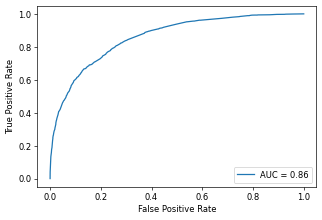

In [17]:
fpr, tpr, thresholds = roc_curve(y_eval, y_pred_proba)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.show()

# Predicciones finales
Finalmente, utilizaremos el modelo para predecir la lluvia de hamburguesas a partir de datos que no fueron usados en el entrenamiento. Guardaremos las predicciones en un archivo csv.

In [21]:
X_train1 = preprocessing_arboles_1(X_train)

clf = tree.DecisionTreeClassifier(random_state=117, max_depth=9, min_samples_leaf=122, criterion='entropy')
clf.fit(X_train1, y_train)

df_pred = pd.read_csv("pred.csv")
df_pred_preprocess = basic_preprocessing(df_pred, prediction_dataset=True)
df_pred_preprocess = fill_numerical_missings(df_pred_preprocess, X_train)
df_pred_preprocess = df_pred_preprocess.drop(columns = ['id'])
df_pred_preprocess = preprocessing_arboles_1(df_pred_preprocess)

y_pred_final = clf.predict(df_pred_preprocess)
df_pred_final = pd.DataFrame({'id': df_pred['id'], 'llovieron_hamburguesas_al_dia_siguiente': y_pred_final})
df_pred_final.loc[df_pred_final['llovieron_hamburguesas_al_dia_siguiente'] == 1, 'llovieron_hamburguesas_al_dia_siguiente'] = 'si'
df_pred_final.loc[df_pred_final['llovieron_hamburguesas_al_dia_siguiente'] == 0, 'llovieron_hamburguesas_al_dia_siguiente'] = 'no'

In [22]:
df_pred_final.to_csv('predicciones/arbol_de_decision.csv', index=False)